# Module Association with Cell Proportion

**Created**: 14 October 2021

## Environment

In [3]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("xCell")) {
    library(remotes)
    install_github("dviraran/xCell")
}

Loading required namespace: patchwork

Loading required namespace: xCell




RSQLite      (2.2.8  -> 2.2.9 ) [CRAN]
BiocGenerics (0.36.0 -> 0.36.1) [CRAN]
xtable       (NA     -> 1.8-4 ) [CRAN]
graph        (NA     -> 1.68.0) [CRAN]
annotate     (NA     -> 1.68.0) [CRAN]
GenomeInfoDb (1.26.4 -> 1.26.7) [CRAN]
GSEABase     (NA     -> 1.52.1) [CRAN]
quadprog     (NA     -> 1.5-8 ) [CRAN]
pracma       (NA     -> 2.3.6 ) [CRAN]
GSVA         (NA     -> 1.38.2) [CRAN]


Installing 10 packages: RSQLite, BiocGenerics, xtable, graph, annotate, GenomeInfoDb, GSEABase, quadprog, pracma, GSVA



✔  checking for file ‘/tmp/RtmpGeL1Oy/remotesb97c214b17db/dviraran-xCell-7339410/DESCRIPTION’
─  preparing ‘xCell’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘xCell_1.1.0.tar.gz’
   


In [4]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(xCell)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [6]:
gene.exp <- read.table("/nfs/team282/data/gains_team282/Logcpm_864_20416.txt")
gene.info <- read.table("/nfs/team282/data/gains_team282/Gene_info_864_20416.txt")

modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
sample.info <- sample.info %>% 
  dplyr::filter(supplier_name %in% rownames(eigengenes))
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]

srs.info <- read.table("/nfs/team282/data/gains_team282/full-gains-SRS-predictions_mNN-RF.tsv", header=T)
srs.info <- srs.info %>%
  dplyr::filter(Assay=="RNA-seq")
row.names(srs.info) <- srs.info$Sample_id
srs.info <- srs.info[rownames(eigengenes),]

cell.prop <- read.table("04_Expression/data/gene_expression/Cell_props_864.txt", header=TRUE)
rownames(cell.prop) <- cell.prop$Sample
cell.prop <- cell.prop[rownames(eigengenes),]

## Association with SRSq

Built a correlation matrix comparing module eigengenes with SRSq for samples.

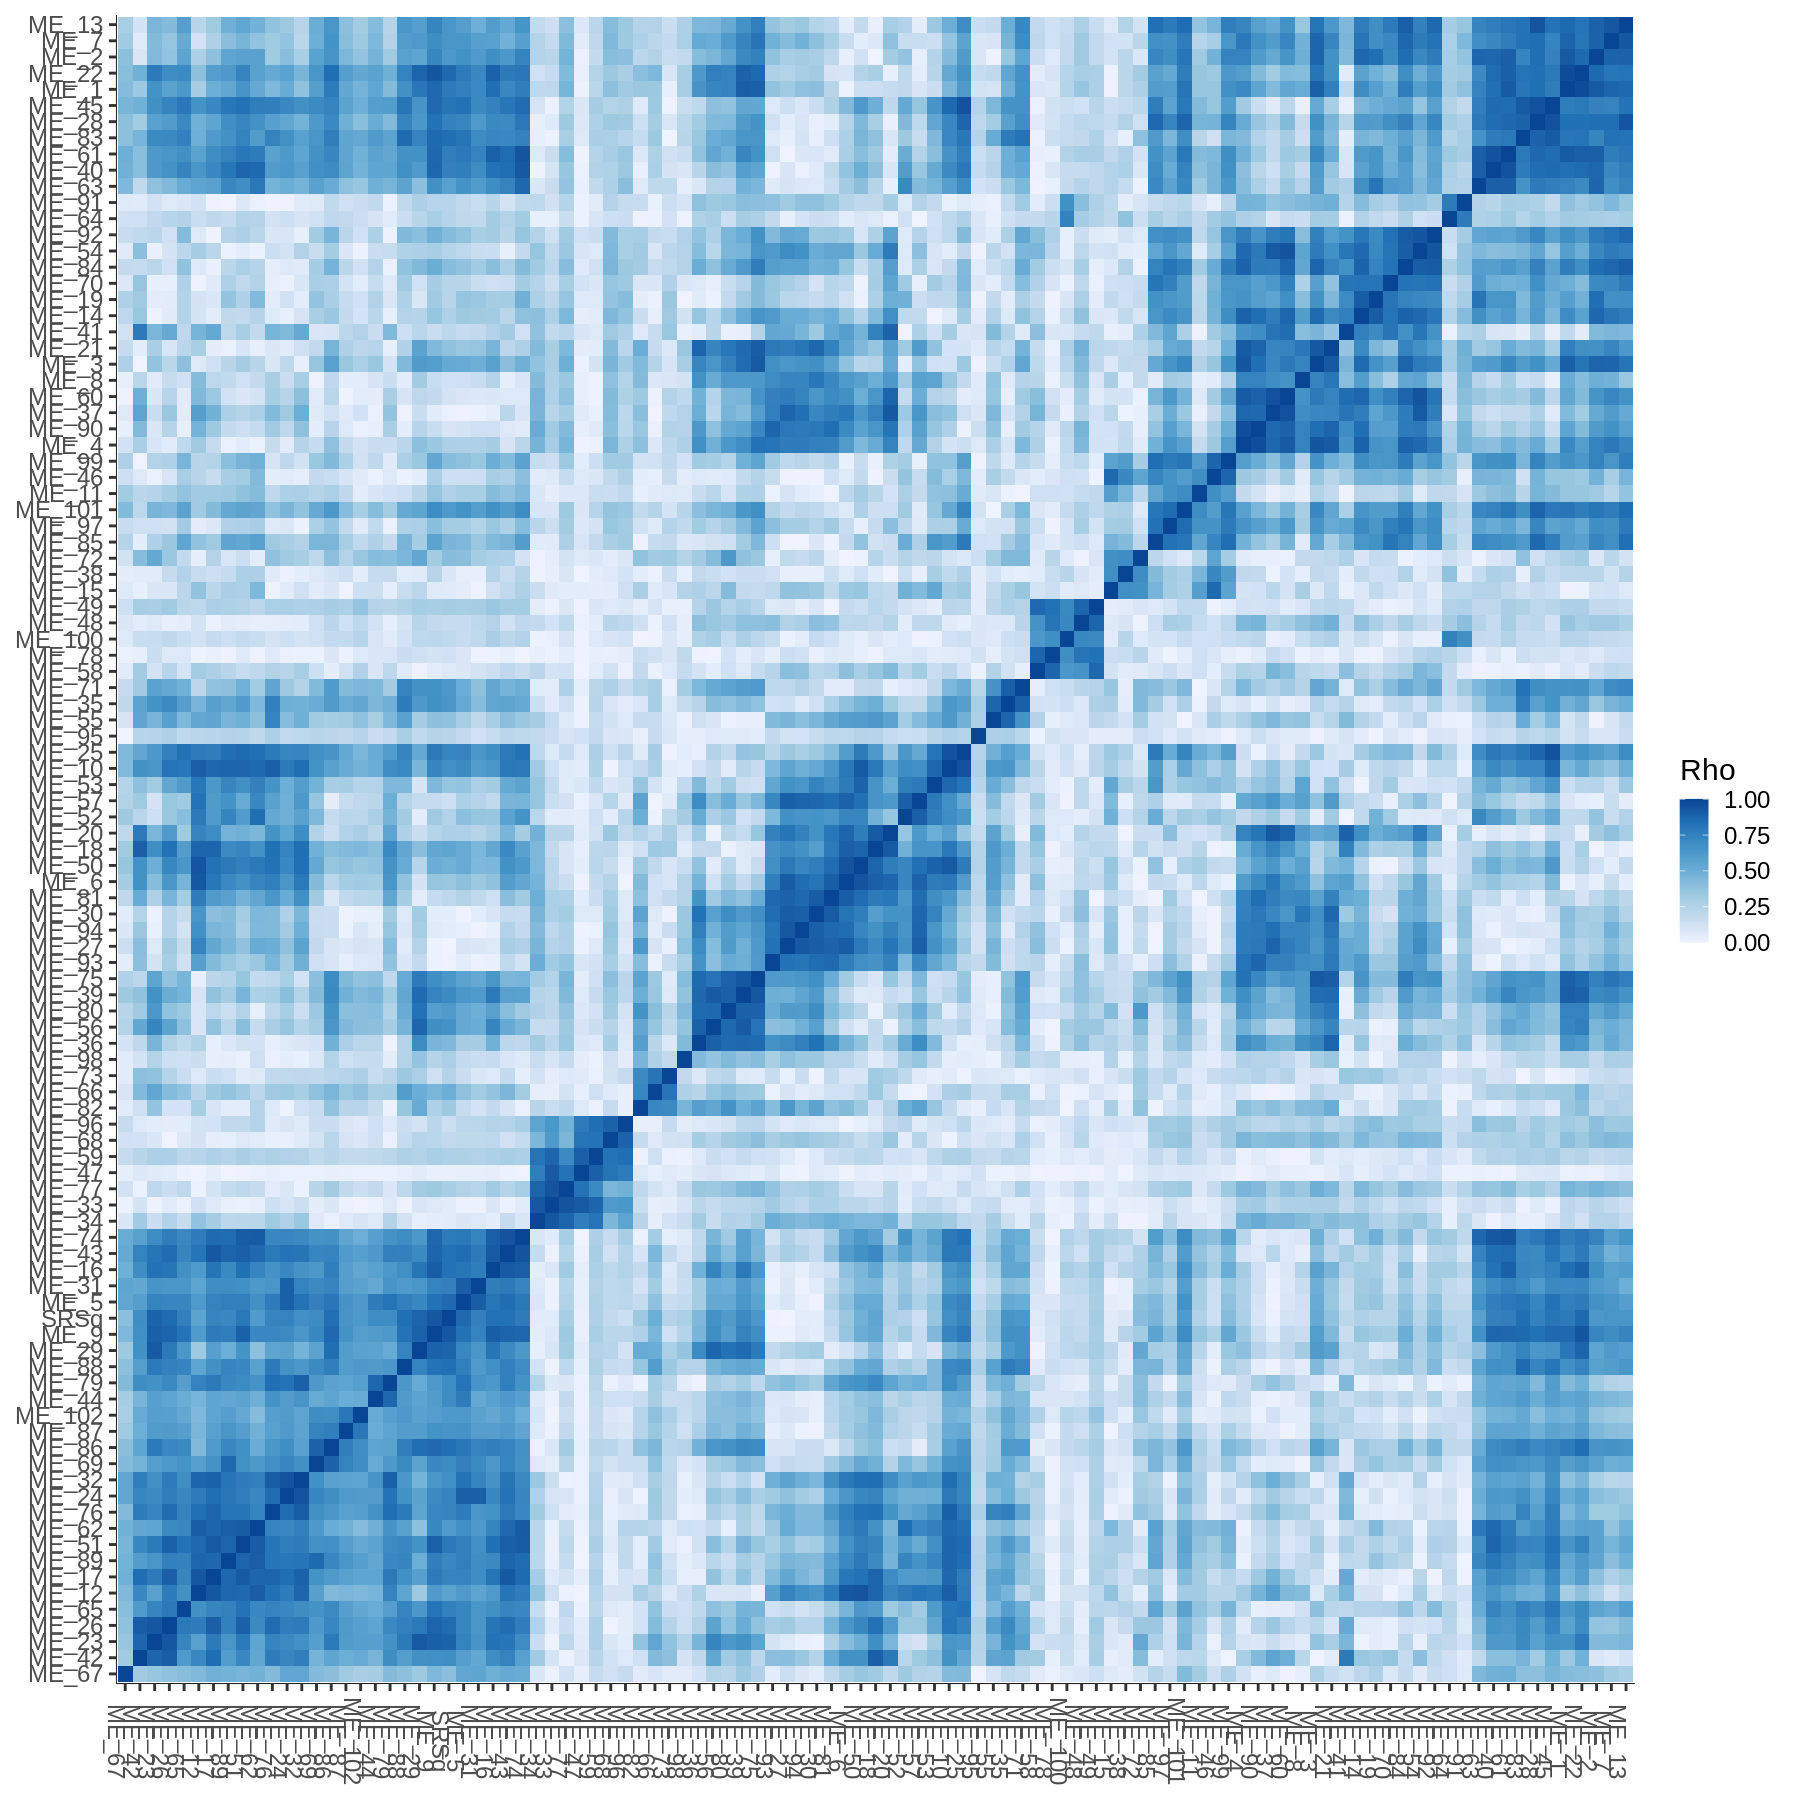

In [7]:
variables <- cbind(eigengenes, srs.info$SRSq)
colnames(variables)[ncol(variables)] <- "SRSq"

rho.values <- abs(cor(variables, method="spearman"))

rho.values.hclust <- hclust(as.dist(1 - rho.values))

options(repr.plot.width=15, repr.plot.height=15)
rho.values %>%
  as.data.frame() %>%
  dplyr::mutate(Variable.2=rownames(.)) %>%
  tidyr::gather("Variable.1", "Rho", -Variable.2) %>%
  dplyr::mutate(Variable.1=factor(Variable.1, levels=colnames(rho.values)[rho.values.hclust$order])) %>%
  dplyr::mutate(Variable.2=factor(Variable.2, levels=colnames(rho.values)[rho.values.hclust$order])) %>%
  ggplot() +
  geom_raster(aes(x=Variable.1, y=Variable.2, fill=Rho)) +
  scale_fill_distiller(palette="Blues", limits=c(0, 1), direction=1) +
  ggplot_theme +
  theme(axis.title=element_blank(), axis.text.x=element_text(angle=270), legend.position="right")
ggsave("04_Expression/results/eigengene_association_with_srsq.svg", width=15, height=15)

Performed significance tests for correlation for Spearman's $\rho$. A significance compares the null hypothesis that $\rho=0$ versus the alternate that $\rho\neq 0$. I use Benjamini-Hochberg p-value adjustment to control for the False Discovery Rate.

In [8]:
estimates <- lapply(colnames(eigengenes), function(eigengene.name) {
  test.result = cor.test(srs.info$SRSq, eigengenes[,eigengene.name], alternative="two.sided", method="spearman", exact=FALSE)
  return(c(test.result$estimate, test.result$p.value))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::select(Rho=1, P.Value=2) %>%
  dplyr::mutate(Eigengene=colnames(eigengenes)) %>%
  dplyr::arrange(desc(abs(Rho))) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Association.Variable="SRSq", Association.Variable.Type="SRSq", Statistic.Type="Rho") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Rho, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.srsq.association.csv")

Since a significant result does not necessarily imply a large effect size, I visualize module eigengenes that are significantly associated with SRSq and also have a large effect size ($|\rho|\geq 0.8$).

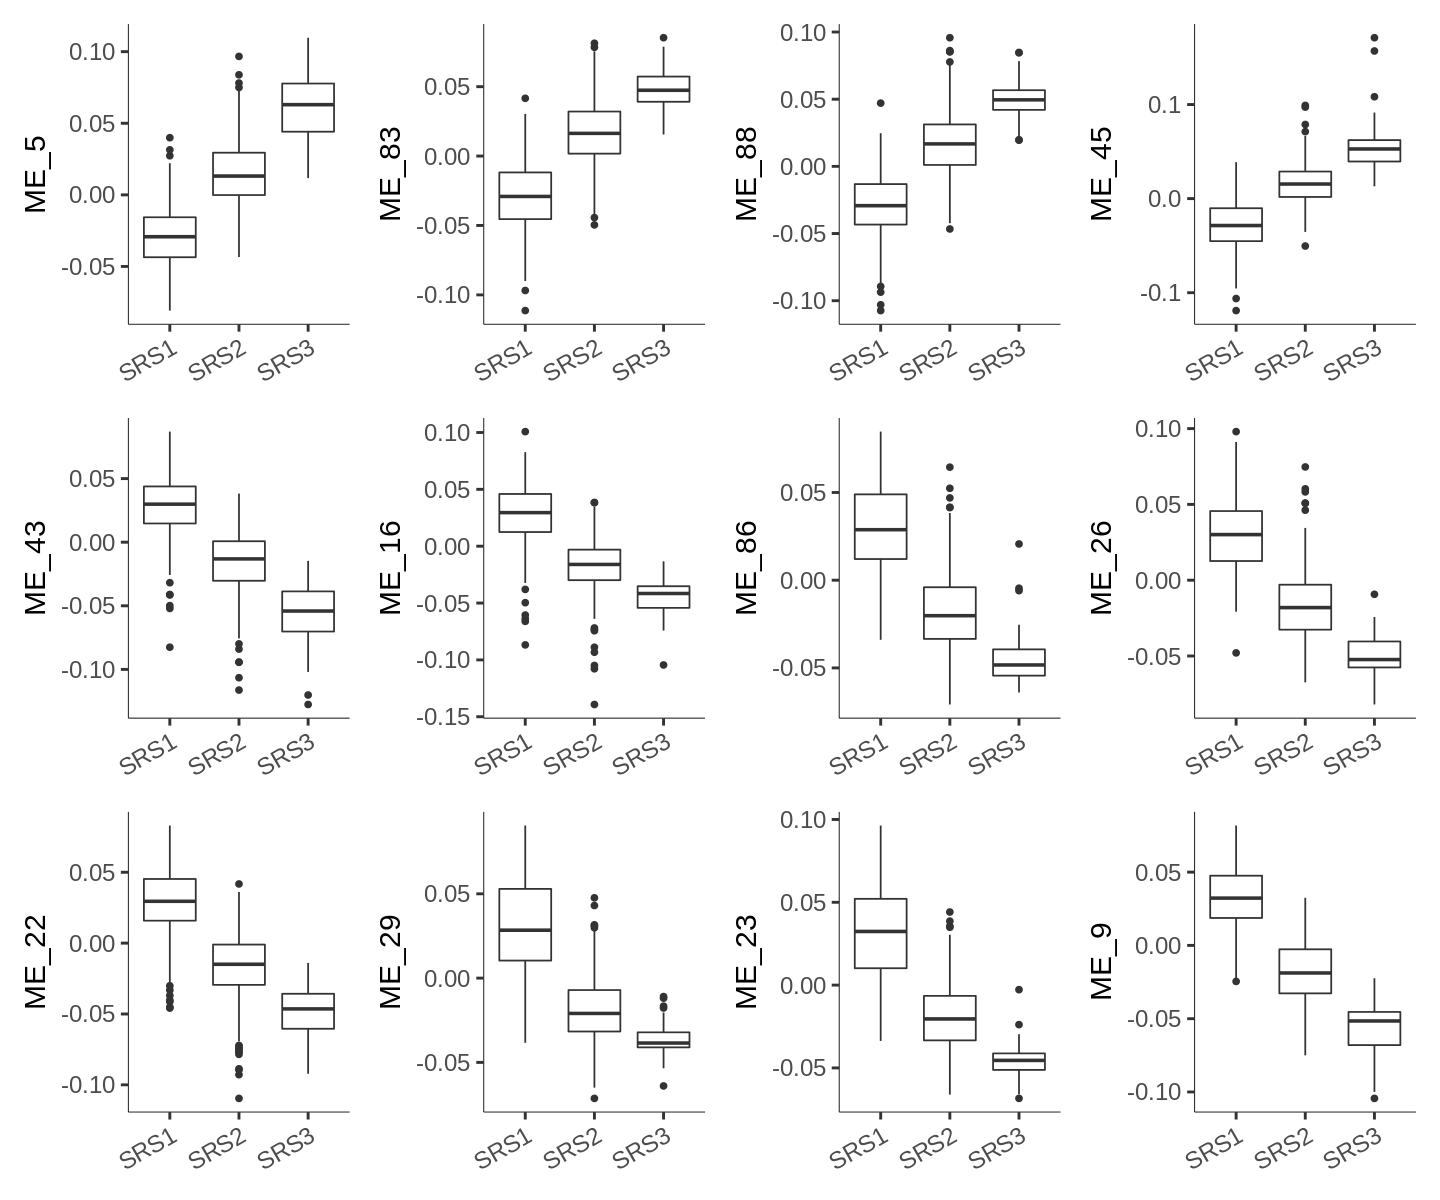

In [10]:
estimates <- estimates %>%
  dplyr::filter(abs(Statistic) >= 0.8, Adjusted.P.Value < 0.05) %>%
  dplyr::arrange(Statistic) %>%
  dplyr::mutate(Eigengene=factor(Eigengene, levels=Eigengene))

# Plot Associated Eigengenes by SRS Group

plots <- lapply(estimates$Eigengene, function(eigengene.name) {
  cbind(srs.info$SRS, eigengenes) %>%
    as.data.frame() %>%
    dplyr::select(SRS=1, everything()) %>%
    ggplot(aes_string(x="SRS", y=as.character(eigengene.name))) +
    geom_boxplot() +
    ggplot_theme +
    theme(axis.title.x=element_blank(), axis.text.x=element_text(angle=30, hjust=1))
})

options(repr.plot.width=12, repr.plot.height=10)
wrap_plots(plots)
ggsave("04_Expression/results/eigengene_association_with_srs_group.svg", width=12, height=10)

## Association with Cell Proportion

Relative cell proportions were measured for most of the samples that have transcriptomic data. There is a large expansion of inflammatory cells during sepsis (especially neutrophils). Similar to SRSq, I perform a significance test for association with Spearman's $\rho$ and adjust p-values using the Benjamini-Hochberg FDR correction.

In [11]:
cell.prop.vars <- cell.prop[,c("Neutrophils", "Lymphocytes", "Monocytes")]

estimates <- lapply(colnames(eigengenes), function(eigengene.name) {
    lapply(colnames(cell.prop.vars), function(cell.type) {
      test.result = cor.test(cell.prop.vars[,cell.type], eigengenes[,eigengene.name], alternative="two.sided", method="spearman", exact=FALSE)
      return(c(test.result$estimate, test.result$p.value, cell.type))
    }) %>%
      do.call(rbind, .) %>%
      as.data.frame() %>%
      dplyr::mutate(Eigengene=eigengene.name)
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::select(Rho=1, P.Value=2, Association.Variable=3, Eigengene) %>%
  dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value)) %>%
  dplyr::arrange(desc(abs(Rho))) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Association.Variable.Type="Cell Proportion", Statistic.Type="Rho") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Rho, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.cell.proportion.association.csv")

## Association with xCell Scores

xCell assigns enrichment scores to samples based on their transcriptomic profiles. xCell derives signatures of specific primary cell types from large consortium datasets.

In [12]:
gene.map <- data.frame(
  Ensembl.ID=rownames(gene.exp)
)

gene.map <- merge(gene.map, gene.info, by.x="Ensembl.ID", by.y="gene_id")
rownames(gene.map) <- gene.map$Ensembl.ID

# Remove genes with duplicate gene names
duplicated.genes <- gene.map$gene_name[duplicated(gene.map$gene_name)]
gene.map <- gene.map %>%
  dplyr::filter(!(gene_name %in% duplicated.genes))

# Remove genes without gene information
xcell.exp <- gene.exp[gene.map$Ensembl.ID,]
rownames(xcell.exp) <- gene.map$gene_name

xcell.analysis <- xCellAnalysis(xcell.exp)

[1] "Num. of genes: 8709"


Warning message in .gsva(expr, mapped.gset.idx.list, method, kcdf, rnaseq, abs.ranking, :
“Some gene sets have size one. Consider setting 'min.sz > 1'.”


Setting parallel calculations through a MulticoreParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 488 gene sets.
  |======================================================================| 100%



I tested for significant association between cell proportions and xCell scores using Spearman's $\rho$ and adjust p-values using the Benjamini-Hochberg FDR correction. I expect the neutrophil, monocyte, and lymphocyte proportions to be associated with xCell scores for granulocytes/neutrophils, B/T/NK lymphocytes, and monocyte/macrophages.

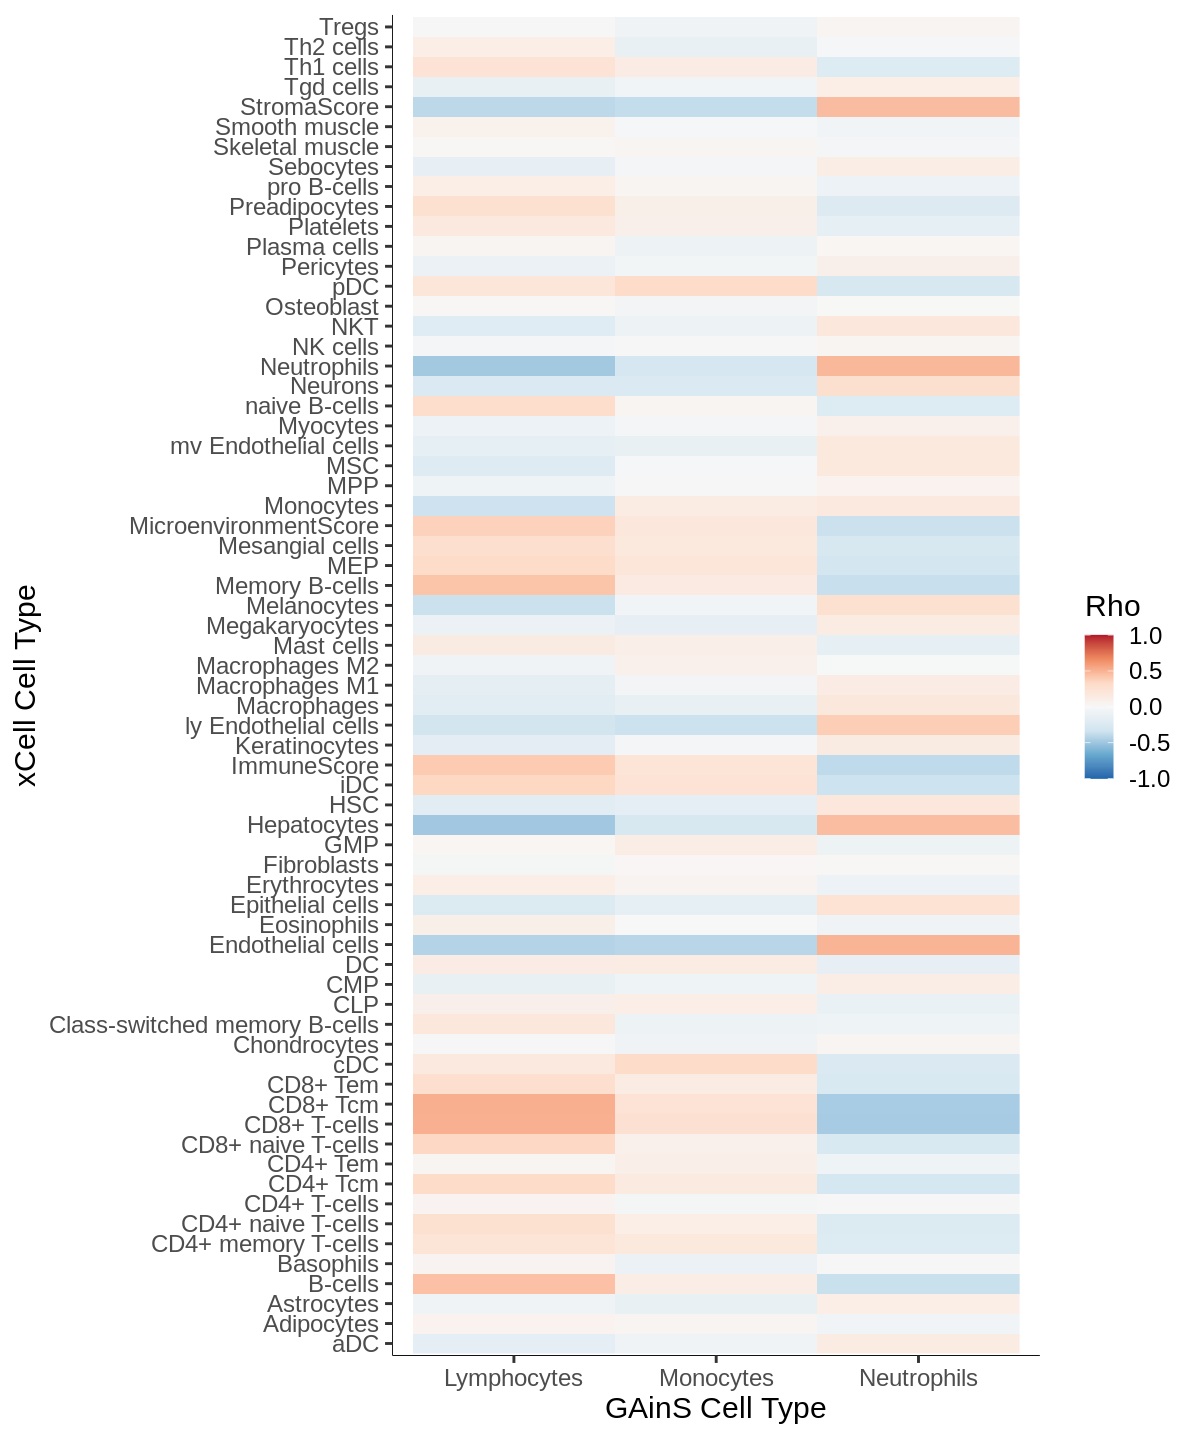

In [13]:
xcell.vars <- t(xcell.analysis)

estimates <- lapply(colnames(cell.prop.vars), function(gains.name) {
  lapply(colnames(xcell.vars), function(xcell.name) {
    test.result = cor.test(cell.prop.vars[,gains.name], xcell.vars[,xcell.name], alternative="two.sided", method="spearman", exact=FALSE)
    return(c(test.result$estimate, test.result$p.value, xcell.name))
  }) %>%
    do.call(rbind, .) %>%
    as.data.frame() %>%
    dplyr::mutate(GAinS.Cell.Type=gains.name) %>%
    dplyr::select(GAinS.Cell.Type, xCell.Cell.Type=3, Rho=1, P.Value=2) %>%
    dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Significance=ifelse(Adjusted.P.Value < 0.05, "*", ""))

options(repr.plot.width=10, repr.plot.height=12)
ggplot(estimates) +
  geom_raster(aes(x=GAinS.Cell.Type, y=xCell.Cell.Type, fill=Rho)) +
  scale_fill_distiller(palette="RdBu", limits=c(-1, 1)) +
  xlab("GAinS Cell Type") + ylab("xCell Cell Type") +
  ggplot_theme +
  theme(legend.position="right")
ggsave("04_Expression/results/cell_type_prop_xcell_association.svg", width=10, height=12)

As done previously, I also tested for significant associations between module eigengenes and xCell scores using Spearman's $\rho$ with p-values adjusted using the Benjamini-Hochberg FDR correction.

In [14]:
estimates <- lapply(colnames(eigengenes), function(eigengene.name) {
  lapply(colnames(xcell.vars), function(xcell.name) {
    test.result = cor.test(eigengenes[,eigengene.name], xcell.vars[,xcell.name], alternative="two.sided", method="spearman", exact=FALSE)
    return(c(abs(test.result$estimate), test.result$p.value, xcell.name))
  }) %>%
    do.call(rbind, .) %>%
    as.data.frame() %>%
    dplyr::mutate(Eigengene=eigengene.name) %>%
    dplyr::select(Eigengene, xCell.Cell.Type=3, Rho=1, P.Value=2) %>%
    dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::select(Rho, P.Value, Association.Variable=xCell.Cell.Type, Eigengene) %>%
  dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value)) %>%
  dplyr::arrange(desc(abs(Rho))) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Association.Variable.Type="xCell Score", Statistic.Type="Rho") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Rho, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.xcell.score.association.csv")

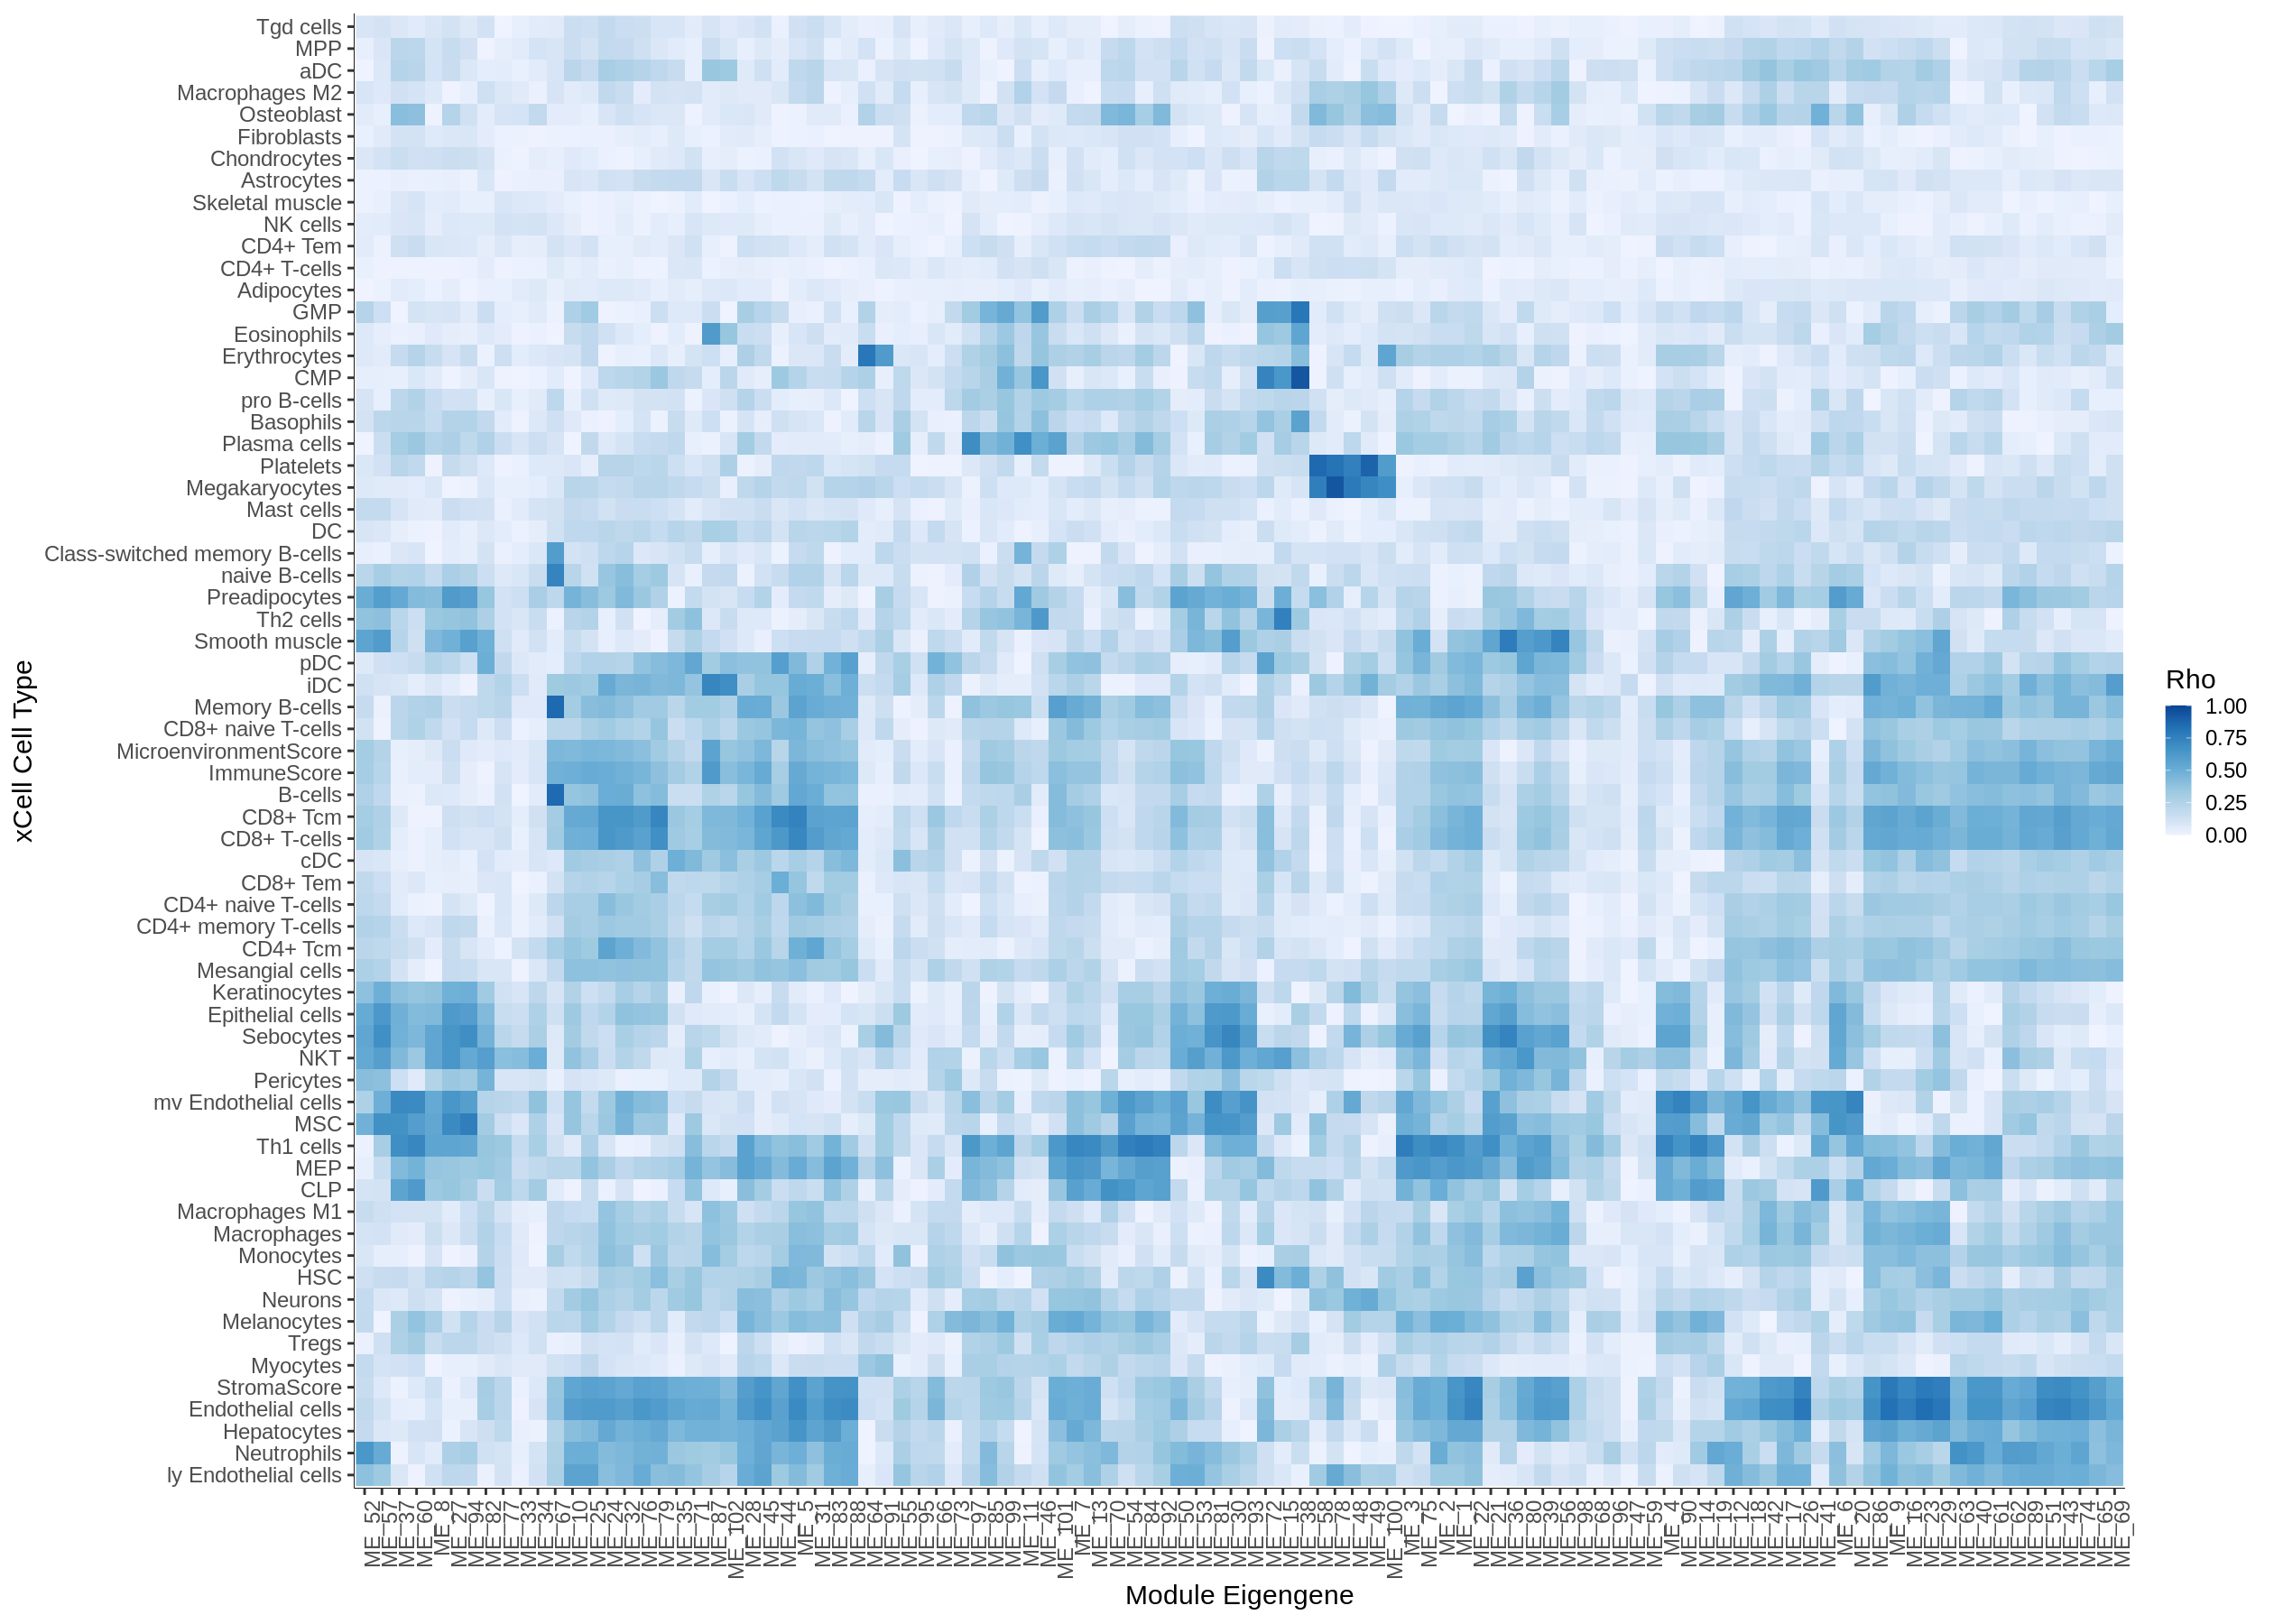

In [15]:
estimates <- estimates %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Significance=ifelse(Adjusted.P.Value < 0.05, "*", "")) %>%
  dplyr::select(xCell.Cell.Type=Association.Variable, Rho=Statistic, everything())

cor.mtx <- cor(eigengenes, xcell.vars, method="spearman")
eigengenes.h <- hclust(dist(cor.mtx))
cell.types.h <- hclust(dist(t(cor.mtx)))
plot.data <- estimates %>%
  dplyr::mutate(Eigengene=factor(Eigengene, levels=colnames(eigengenes)[eigengenes.h$order])) %>%
  dplyr::mutate(xCell.Cell.Type=factor(xCell.Cell.Type, levels=colnames(xcell.vars)[cell.types.h$order]))

options(repr.plot.width=21, repr.plot.height=15)
ggplot(plot.data) +
  geom_raster(aes(x=Eigengene, y=xCell.Cell.Type, fill=Rho)) +
  scale_fill_distiller(palette="Blues", limits=c(0, 1), direction=1) +
  xlab("Module Eigengene") + ylab("xCell Cell Type") +
  ggplot_theme +
  theme(legend.position="right", axis.text.x=element_text(angle=90, hjust=1))
ggsave("04_Expression/results/eigengene_xcell_association.svg", width=21, height=15)

## Overrepresentation Analysis with xCell Signatures

xCell enrichment scores are defined based on cell signatures (sets of genes associated with each primary cell type). We can test if any of these signatures are enriched in our modules. Depending on which dataset was used to derive the signature, the xCell list is slightly different. I test for overrepresentation in all signatures independently. For example, I would test for enrichment in all the different neutrophil signatures present in xCell.

I use Fisher's exact test (which is equivalent to a hypergeometric test with a one-sided alternative). The p-values are adjusted using Benjamini-Hochberg FDR correction. I report the mean, minimum, and maximum odds ratio for significant associations from a given cell type. For example, I would report the mean/medium/maximum odds ratio for the different neutrophil signatures.

In [16]:
# Reduce Modules to Genes with Gene Names
modules.list <- modules %>%
  dplyr::filter(Gene %in% gene.map$Ensembl.ID) %>%
  merge(., gene.map, by.x="Gene", by.y="Ensembl.ID") %>%
  dplyr::select(Gene=gene_name, Module) %>%
  split(., .$Module)

# Perform Overrepresentation Test

signature.cell.types <- sapply(strsplit(names(xCell.data$signatures), "%"), function(x) x[1])
unique.cell.types <- unique(signature.cell.types)

gene.lists <- list()

for (cell.type in unique.cell.types) {
  n.signatures = sum(signature.cell.types == cell.type)
  gene.lists[[cell.type]] = lapply(1:n.signatures, function(i) {
    xCell.data$signatures[signature.cell.types == cell.type][[i]]@geneIds
  })
}

ora.results <- list()
ora.results[["Module"]] <- list()
ora.results[["Cell.Type"]] <- list()
ora.results[["Odds.Ratio"]] <- list()
ora.results[["P.Value"]] <- list()
counter <- 0

for (module in names(modules.list)) {

  for (cell.type in unique.cell.types) {
  
    for (i in 1:length(gene.lists[[cell.type]])) {
      
      counter <- counter + 1
      
      gene.list = gene.lists[[cell.type]][[i]]
      module.list = modules.list[[module]]$Gene
      
      within.module.and.gene.set = length(intersect(gene.list, module.list))
      within.module.outside.gene.set = length(module.list) - within.module.and.gene.set
      outside.module.within.gene.set = length(intersect(gene.list, setdiff(gene.map$gene_name, module.list)))
      outside.module.outside.gene.set = length(setdiff(gene.map$gene_name, module.list)) - outside.module.within.gene.set
      
      contingency.mtx = data.frame(
        within.module=c(within.module.and.gene.set, within.module.outside.gene.set),
        outside.module=c(outside.module.within.gene.set, outside.module.outside.gene.set)
      )
      rownames(contingency.mtx) = c("within.gene.set", "outside.gene.set")
      test.result = fisher.test(contingency.mtx, alternative="greater")
      
      ora.results[["Module"]][[counter]] <- module
      ora.results[["Cell.Type"]][[counter]] <- cell.type
      ora.results[["Odds.Ratio"]][[counter]] <- test.result$estimate
      ora.results[["P.Value"]][[counter]] <- test.result$p.value
    }
  }
}

ora.results.df <- as.data.frame(lapply(ora.results, unlist))

filtered.cell.type.enrichment <- ora.results.df %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::filter(Adjusted.P.Value < 0.05) %>%
  dplyr::group_by(Module, Cell.Type) %>%
  dplyr::summarize(Mean.Odds.Ratio=mean(Odds.Ratio), Odds.Ratio.Min=min(Odds.Ratio), Odds.Ratio.Max=max(Odds.Ratio)) %>%
  dplyr::arrange(Module, desc(Mean.Odds.Ratio))

write.csv(filtered.cell.type.enrichment, "~/gains_team282/nikhil/expression/gene_expression/module.xcell.signature.enrichment.csv")

`summarise()` has grouped output by 'Module'. You can override using the `.groups` argument.



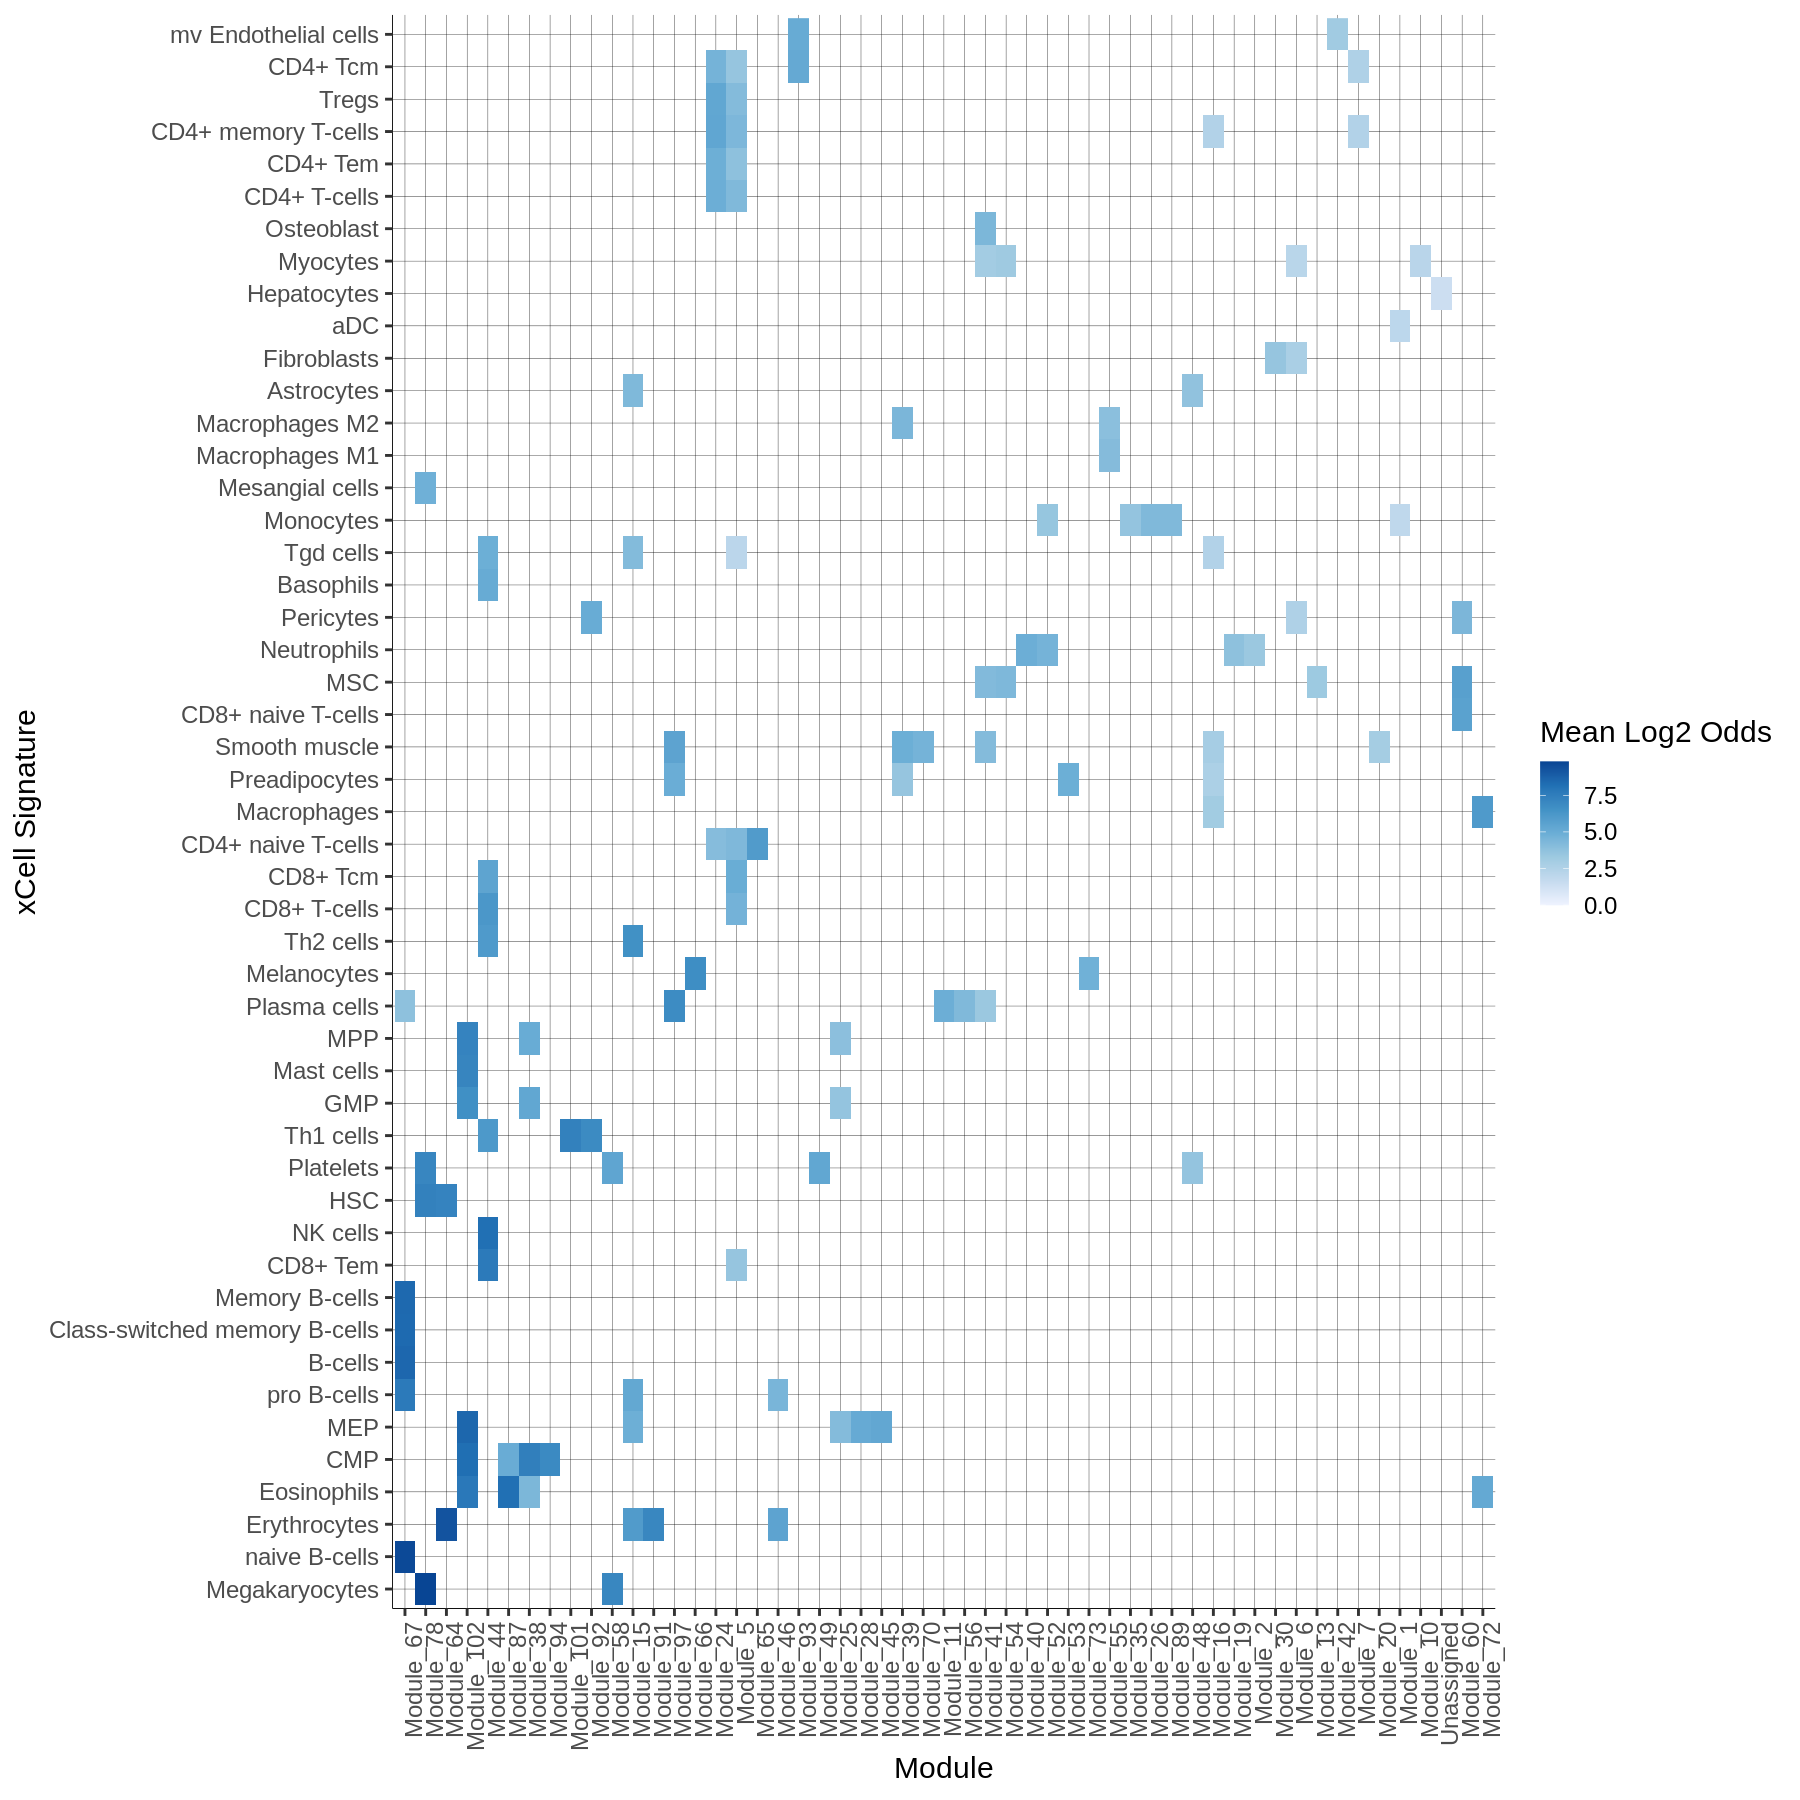

In [17]:
mtx <- filtered.cell.type.enrichment %>%
  dplyr::select(Module, Cell.Type, Mean.Odds.Ratio) %>%
  tidyr::spread(Module, Mean.Odds.Ratio) %>%
  replace(is.na(.), 0) %>%
  as.data.frame
rownames(mtx) <- mtx$Cell.Type
mtx <- mtx[,-1]
cell.type.h <- hclust(dist(mtx))
module.h <- hclust(dist(t(mtx)))

plot.data <- filtered.cell.type.enrichment %>%
  dplyr::mutate(Mean.Log.2.Odds=log2(Mean.Odds.Ratio)) %>%
  dplyr::mutate(Module=factor(Module, levels=colnames(mtx)[module.h$order])) %>%
  dplyr::mutate(Cell.Type=factor(Cell.Type, levels=rownames(mtx)[cell.type.h$order]))

options(repr.plot.width=15, repr.plot.height=15)
ggplot(plot.data) +
  geom_raster(aes(x=Module, y=Cell.Type, fill=Mean.Log.2.Odds)) +
  scale_fill_distiller(palette="Blues", direction=1, limits=c(0, max(plot.data$Mean.Log.2.Odds))) +
  xlab("Module") + ylab("xCell Signature") +
  labs(fill="Mean Log2 Odds") +
  ggplot_theme +
  theme(axis.text.x=element_text(angle=90, hjust=1), legend.position="right", panel.grid.major=element_line(size=0.1))
ggsave("04_Expression/results/module_xcell_signature_enrichment.svg", width=15, height=15)